<a href="https://colab.research.google.com/github/Sanyam-oss/Online-Near-Duplicate-Detection/blob/main/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifier Model to detect duplicate pairs**

Dataset : https://www.kaggle.com/competitions/quora-question-pairs/data

*Key features* about the data :

1. Data is labelled - `Binary Classification ()` problem

2. Labels have been supplied by humans, so truth labels are inherently subjective. Therefore, the `labels` on this dataset should be taken as informed and `not 100% accurate`.

---

**Problem Statement** 

`Given two questions we have to classify whether they are duplicates or not`.

---

**Background**

Currently, Quora uses a `Random Forest model` to identify duplicate questions.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import OrderedDict
import operator
import nltk
from nltk import bigrams, trigrams, word_tokenize
from collections import Counter, defaultdict

import re
from bs4 import BeautifulSoup

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
df = pd.read_csv("drive/MyDrive/Quora_Dataset/train.csv")

In [16]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [17]:
def _preprocess(q):     # Based on some observations from the EDA and Kaggle articles
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'billion ')
    q = q.replace(',000,000 ', 'million ')
    q = q.replace(',000 ', 'thousand ')

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q
    

In [18]:
print(_preprocess("I've already seen that movie?"))


i have already seen that movie


In [20]:
df['question1'] = df['question1'].apply(_preprocess)
df['question2'] = df['question2'].apply(_preprocess)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [21]:
new_df = df
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0


In [26]:
new_df.to_csv('content\drive\My Drive\Quora_Dataset\qqd_csv_file.csv', encoding='utf-8', index=False)

In [27]:
# From EDA taking some useful features

df["len1"] = df["question1"].str.len()
df["len2"] = df["question2"].str.len()

df["word1"] = df["question1"].str.strip().str.split().str.len()
df["word2"] = df["question2"].str.strip().str.split().str.len()

def to_lower(d):
  a = [[x.lower() for x in s] for s in d]
  return a 

def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1|w2))

df['common_words'] = df.apply(common_words, axis=1)
df['word_total'] = df.apply(total_words, axis=1)            # ? Should it be union or sum of unique words in both
df['word_share'] = round(df['common_words']/df['word_total'],2)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len1,len2,word1,word2,common_words,word_total,word_share
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11,12,0.92
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,10,15,8,18,0.44
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4,20,0.20
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,11,12,1,21,0.05
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,13,7,4,17,0.24


In [32]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
token_features = new_df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [35]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len1,len2,word1,word2,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,...,12,0.92,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,10,15,...,18,0.44,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,...,20,0.20,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,11,12,...,21,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,13,7,...,17,0.24,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0


In [62]:
!pip install Distance
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0,0.0,0.0]
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))

    if(len(strs) == 0):
      length_features[2] = 0 

    else:
      length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features
  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [65]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len1,len2,word1,word2,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,...,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,0.982456
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,10,15,...,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,0.588235
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,...,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,0.169492
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,11,12,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,11.5,0.040000
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,13,7,...,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,0.153846


In [66]:
# Fuzzy Features
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [67]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [68]:
print(df.shape)
df.head()

(404290, 28)


,id,qid1,qid2,question1,question2,is_duplicate,len1,len2,word1,word2,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,...,0.785709,0.0,1.0,2.0,13.0,0.982456,93,100,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,10,15,...,0.466664,0.0,1.0,5.0,12.5,0.588235,66,74,63,86
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,...,0.285712,0.0,1.0,4.0,12.0,0.169492,43,46,63,63
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0,49,58,11,12,...,0.000000,0.0,0.0,1.0,11.5,0.040000,9,11,25,28
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,75,38,13,7,...,0.307690,0.0,1.0,6.0,10.0,0.153846,35,55,47,67


In [69]:
df.to_csv('content\drive\My Drive\Quora_Dataset\qqd_features.csv', encoding='utf-8', index=False)

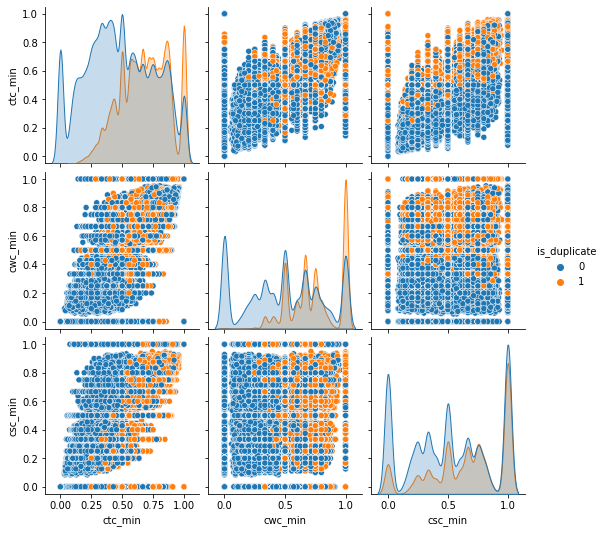

In [70]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

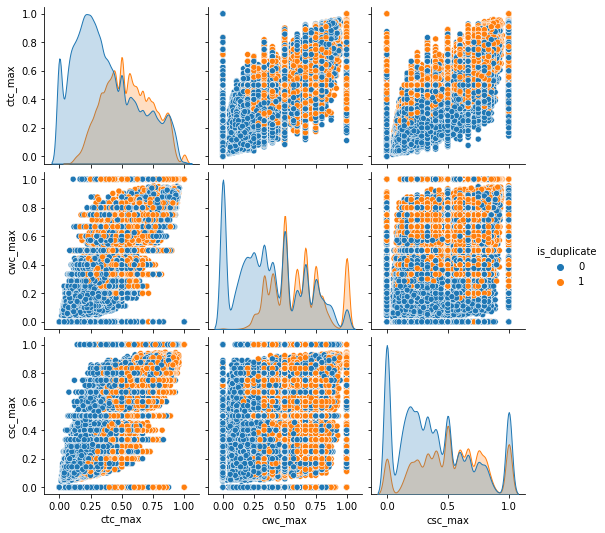

In [71]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

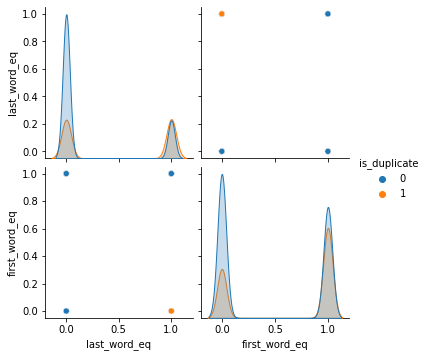

In [72]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

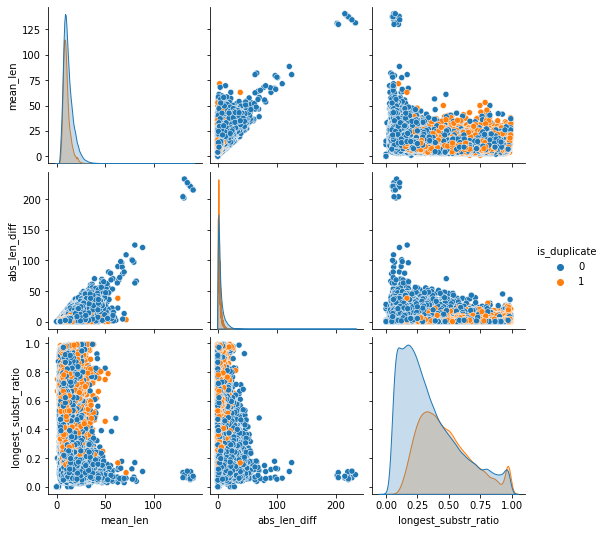

In [73]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

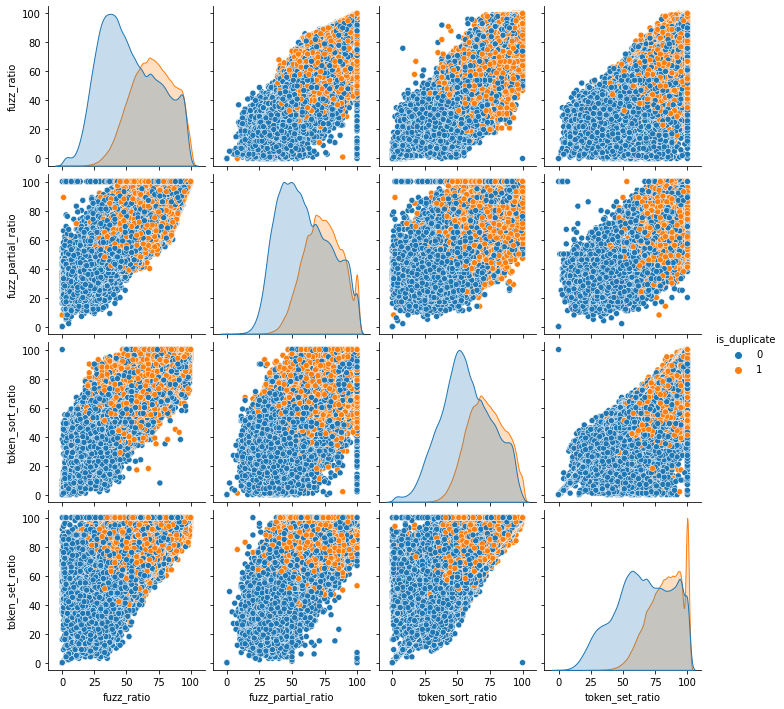

In [74]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')